In [428]:
import torch
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [429]:
import json

# Load the label mapping
with open('./content/squeezenet-labels.json') as f:
    label_mapping = json.load(f)


In [430]:
model = models.squeezenet1_1(pretrained=True)

/home/highorder/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/highorder/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [431]:
# input_image = "./content/dog.png"  # Provide the path to your input image
# image = Image.open(input_image).convert("RGB")  # Convert image to RGB format
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def compress(degree=128):
    """
    Compress the image to a smaller size.

    Args:
    - degree (int): The size to resize the image to. Default is 128.

    Returns:
    - transforms.Compose: A composed transform that resizes and converts the image to a tensor.

    Example:
    >>> transform = compress(degree=100)
    >>> transformed_image = transform(image)
    """
    return transforms.Compose([
        transforms.Resize(degree),
        transforms.ToTensor(),
    ])

def random_cropping(size=224):
    """
    Randomly crop the image to a specified size.

    Args:
    - size (int): The size of the crop. Default is 224.

    Returns:
    - transforms.Compose: A composed transform that randomly crops and converts the image to a tensor.

    Example:
    >>> transform = random_cropping(size=200)
    >>> transformed_image = transform(image)
    """
    return transforms.Compose([
        transforms.RandomResizedCrop(size),
        transforms.ToTensor(),
    ])

def random_padding(padding=10, size=224):
    """
    Add random padding to the image and then crop it to a specified size.

    Args:
    - padding (int): The amount of padding to add. Default is 10.
    - size (int): The size of the crop after padding. Default is 224.

    Returns:
    - transforms.Compose: A composed transform that pads, crops, and converts the image to a tensor.

    Example:
    >>> transform = random_padding(padding=15, size=200)
    >>> transformed_image = transform(image)
    """
    return transforms.Compose([
        transforms.Pad(padding),
        transforms.RandomCrop(size),
        transforms.ToTensor(),
    ])
    

def reverse_normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Reverse the normalization of a tensor.
    
    Args:
    - tensor (torch.Tensor): The normalized tensor.
    - mean (list): The mean used for normalization.
    - std (list): The standard deviation used for normalization.
    
    Returns:
    - torch.Tensor: The unnormalized tensor.
    """
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    return tensor * std + mean

# processed_image = preprocess(image).unsqueeze(0)



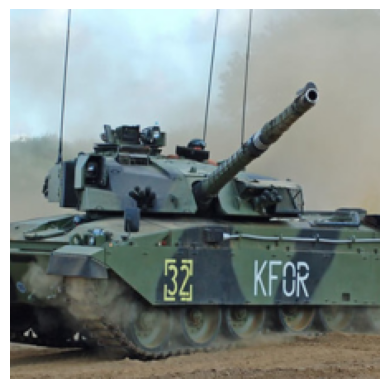

In [432]:
path = './data/imagenet/847'
#todo, add new classes other then tanks
# Load all images in the folder and convert them to RGB
import os
image_paths = [os.path.join(path, img) for img in os.listdir(path) if img.endswith('.jpg')]
images = [Image.open(img_path).convert("RGB") for img_path in image_paths]
images_other = [Image.open(img_path).convert("RGB") for img_path in image_paths]

images = [preprocess(image).unsqueeze(0) for image in images]


# Reverse normalize the image
unnormalized_image = reverse_normalize(images[0]).squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

# Display the image
plt.imshow(unnormalized_image)
plt.axis('off')
plt.show()

In [433]:
def show_image_label(image, label):
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    plt.show()

def print_top_predictions(output, label_mapping, top_k=5):
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    top5_prob, top5_catid = torch.topk(probabilities, top_k)

    print("Top 5 Predictions:")
    for i in range(top5_prob.size(0)):
        label = label_mapping[str(top5_catid[i].item())]
        percentage = top5_prob[i].item() * 100
        print(f'{label}: {percentage:.2f}%')

def show_image_and_predictions(image, output, label_mapping, top_k=5):
    # Check if the image has 4 dimensions and squeeze if necessary
    if image.dim() == 4:
        image = image.squeeze(0)
    
    # Show the image
    plt.imshow(image.permute(1, 2, 0).cpu().detach().numpy())
    plt.axis('off')
    plt.show()
    
    # Get the top predictions
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    #probabilities.shape = [1000]
    # its a estiamte of likelihood of each of the 1000 classes

    top5_prob, top5_catid = torch.topk(probabilities, top_k)
    # shape = [5] they are 5 rank 1 tensors each
    
    # Print the top predictions
    print_top_predictions(output, label_mapping, top_k)

    return probabilities




In [434]:
def attack_BIM(mean, std, model, image, class_index, epsilon, alpha, num_iterations=10):
    '''
    Applies given number of steps of the Basic Iterative Method (BIM) attack on the input image.
    
    Inputs:
    mean           -- Mean from data preparation
    std            -- Standard deviation from data preparation
    model          -- Network under attack
    image          -- Image data as tensor of shape (1, 3, 224, 224)
    class_index    -- Label from image as numpy array   
    epsilon        -- Hyperparameter for sign method. Has to be scaled to epsilon/255
    alpha          -- Hyperparameter for iterative step as absolute value. Has to be scaled to alpha/255
    num_iterations -- Number of iterations to perform. Default is 10. It is recommended to use the heuristic from the
                      paper "Adversarial Examples in the Pysical World" to determine the number of iterations
    
    Returns:
    image_adver    -- Adversarial image as tensor
    '''

    # Convert label to torch tensor of shape (1)
    class_index = torch.tensor([class_index])

    # Check input image and label shapes
    assert(image.shape == torch.Size([1, 3, 224, 224]))
    assert(class_index.shape == torch.Size([1]))
    
    # Initialize adversarial image as image according to equation 2.1
    image_adver = image.clone()    
    
    # Calculate normalized range [0, 1] and convert them to tensors
    zero_normed = [-m/s for m,s in zip(mean, std)]
    zero_normed = torch.tensor(zero_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    max_normed = [(1-m)/s for m,s in zip(mean,std)]
    max_normed = torch.tensor(max_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    # Calculate normalized alpha
    alpha_normed = [alpha/s for s in std]
    alpha_normed = torch.tensor(alpha_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)

    # Calculated normalized epsilon and convert it to a tensor
    eps_normed = [epsilon/s for s in std]
    eps_normed = torch.tensor(eps_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    # Calculate the maximum change in pixel value using epsilon to be later used in clip function
    image_plus = image + eps_normed
    image_minus = image - eps_normed
    
    for i in range(num_iterations):
        
        # Make a copy and detach so the computation graph can be constructed
        image_adver = image_adver.clone().detach()
        image_adver.requires_grad=True
        
        # Compute cost with example image_adversarial        
        pred = model(image_adver)        
        loss = F.nll_loss(pred, class_index)        
        model.zero_grad()        
        loss.backward()        
        grad_x = image_adver.grad.data       
        
        # Check if gradient exists
        assert(image_adver.grad is not None)
               
        # Compute X_prime according to equation 2.2
        image_prime = image_adver + alpha_normed * grad_x.detach().sign()
        assert(torch.equal(image_prime, image_adver) == False)
      
        # Equation 2.3 part 1
        third_part_1 = torch.max(image_minus, image_prime)
        third_part = torch.max(zero_normed, third_part_1)
              
        # Equation 2.3 part 2
        image_adver = torch.min(image_plus, third_part)                 
        image_adver = torch.min(max_normed, image_adver)                        

    return image_adver

In [435]:
import torch.nn.functional as F


In [436]:

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
epsilon = 0.025
alpha = 0.01
num_iterations = 10
class_index = torch.tensor([847])  # Example class index




# Create a list of adversarial images
adversarial_images = [attack_BIM(mean, std, model, img, class_index, epsilon, alpha, num_iterations) for img in images]


In [437]:
adversarial_images_unnormalized = [reverse_normalize(img) for img in adversarial_images]


## class based processing

In [438]:
from ignite.metrics import SSIM
from ignite.engine import Engine

In [439]:
from typing import Union, List
import torchvision.transforms.functional as TF

class ImageProcessor:
    def __init__(self, images, model, class_index_num):
        self.images = images
        self.model = model
        self.class_index = torch.tensor([class_index_num])
        self.image_data = {
            "processed": [],
            "adversarial": [],
            "adversarial_unnormalized": []
        }
        self.predictions = {
            "processed": [],
            "adversarial": []
        }
        self.loss_dict = {}

    def batch_images(self,image_list):
    # Squeeze the tensors and stack them along the first dimension to create a batch
        squeezed_images = [img.squeeze() for img in image_list]
        return torch.stack(squeezed_images)

    def display_losses(self):
        for key, losses in self.loss_dict.items():
            median_loss = np.median(losses)
            print(f"Median loss for {key}: {median_loss}")

    def calc_loss(self, image_key):
        if image_key not in self.image_data:
            raise ValueError(f"{image_key} not found in image data.")
        criterion = torch.nn.CrossEntropyLoss()
        losses = []
        for img in self.image_data[image_key]:
            output = self.model(img)
            loss = criterion(output, self.class_index)
            losses.append(loss.item())
        self.loss_dict[image_key] = losses

    def display_images(self, album: str, image_number: Union[int, List[int]]):
        """
        Display images from a specified album.

        Parameters:
        album (str): The key for the album in the image_data dictionary.
        image_number (int or list of ints): The index or indices of images to display.

        Raises:
        ValueError: If the album is not found in image_data or if image_number is not an int or list of ints.

        Example:
        processor = ImageProcessor(images, model, class_index_num)
        processor.display_images('processed_images', 0)
        processor.display_images('adversarial_images', [0, 1, 2])
        """
        if album not in self.image_data:
            raise ValueError(f"{album} not found in image data.")
        images_to_display = self.image_data[album]
        if isinstance(image_number, int):
            images_to_display = [images_to_display[image_number]]
        elif isinstance(image_number, list):
            images_to_display = [images_to_display[i] for i in image_number]
        else:
            raise ValueError("image_number should be an int or a list of ints.")
        
        for img in images_to_display:
            plt.imshow(reverse_normalize(img).squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
            plt.show()

    def copy_images(self, source_key, dest_key):
        if source_key not in self.image_data:
            raise ValueError(f"{source_key} not found in image data.")
        self.image_data[dest_key] = self.image_data[source_key].copy()

    def compress(self, image_key, scale_factor=0.8):
        if image_key not in self.image_data:
            raise ValueError(f"{image_key} not found in image data.")
        self.image_data[image_key] = [
            F.interpolate(img, scale_factor=scale_factor, mode='bilinear', align_corners=False)
            for img in self.image_data[image_key]
        ]

    def add_gaussian_noise(self, image_key, mean=0.0, std=0.05):
        if image_key not in self.image_data:
            raise ValueError(f"{image_key} not found in image data.")
        self.image_data[image_key] = [
            torch.clamp(img + torch.randn(img.size()) * std + mean, 0.0, 1.0)
            for img in self.image_data[image_key]
        ]

    def random_padding(self, image_key, padding=10, size=224):
        if image_key not in self.image_data:
            raise ValueError(f"{image_key} not found in image data.")
        random_pad = random_padding(padding=padding, size=size)
        self.image_data[image_key] = [random_pad(img) for img in self.image_data[image_key]]

    
    # def bit_depth_reduction(self, image_key):
    #     if image_key not in self.image_data:
    #         raise ValueError(f"{image_key} not found in image data.")
    #     self.image_data[image_key] = [reduce_bit_depth(img) for img in self.image_data[image_key]]

    def compare_albums(self, image_key1, image_key2):
        if image_key1 not in self.image_data:
            raise ValueError(f"{image_key1} not found in image data.")
        if image_key2 not in self.image_data:
            raise ValueError(f"{image_key2} not found in image data.")
        
        if f"{image_key1}_unnormalized" not in self.image_data:
            self.unnormalize_album(image_key1)
        if f"{image_key2}_unnormalized" not in self.image_data:
            self.unnormalize_album(image_key2)
        
        images1 = self.batch_images(self.image_data[f"{image_key1}_unnormalized"])
        images2 = self.batch_images(self.image_data[f"{image_key2}_unnormalized"])
        

        # donno what this does
        metric = SSIM(data_range=1.0)
        def eval_step(engine, batch):
            return batch
        evaluator = Engine(eval_step)
        metric.attach(evaluator, 'ssim')
        state = evaluator.run([[images1, images2]])

        return state.metrics['ssim']

        

    def process_images(self):
        self.image_data["processed"] = [preprocess(image).unsqueeze(0) for image in self.images]

    def tensor_preprocess(self, image_tensor):
        if image_tensor.ndim == 4:
            image_tensor = image_tensor.squeeze(0)
        image_tensor = TF.resize(image_tensor, size=[224, 224])
        mean = torch.tensor([0.485, 0.456, 0.406], dtype=image_tensor.dtype, device=image_tensor.device).view(-1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], dtype=image_tensor.dtype, device=image_tensor.device).view(-1, 1, 1)
        normalized_tensor = (image_tensor - mean) / std
        return normalized_tensor

    def reprocess_images(self, image_key):
        if image_key not in self.image_data:
            raise ValueError(f"{image_key} not found in image data.")
        self.image_data[image_key] = [self.tensor_preprocess(image).unsqueeze(0) for image in self.image_data[image_key]]




    def attack_BIM_all(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], epsilon=0.025, alpha=0.01, num_iterations=10):
        if not self.image_data["processed"]:
            raise ValueError("Images need to be processed first.")
        self.image_data["adversarial"] = [attack_BIM(mean, std, self.model, img, self.class_index, epsilon, alpha, num_iterations) for img in self.image_data["processed"]]

    def unnormalize_album(self, image_key):
        if image_key not in self.image_data:
            raise ValueError(f"{image_key} not found in image data.")
        if not self.image_data[image_key]:
            raise ValueError(f"No images found for {image_key}.")
        self.image_data[f"{image_key}_unnormalized"] = [reverse_normalize(img) for img in self.image_data[image_key]]
        return self

    def display_first_image(self):
        if not self.image_data["processed"]:
            raise ValueError("Images need to be processed first.")
        first_processed_image = self.image_data["processed"][0]
        plt.imshow(reverse_normalize(first_processed_image).squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.title("First Processed Image")
        plt.show()

    def make_predictions(self, image_key):
        if image_key not in self.image_data:
            raise ValueError(f"{image_key} not found in image data.")
        
        def check_and_reshape(img):
            if img.shape != torch.Size([1, 3, 224, 224]):
                img = img.unsqueeze(0)
            if img.shape != torch.Size([1, 3, 224, 224]):
                raise ValueError(f"Image tensor has incorrect shape: {img.shape}")
            return img
        
        self.predictions[image_key] = [torch.nn.functional.softmax(self.model(check_and_reshape(img)), dim=1).detach().cpu().numpy() for img in self.image_data[image_key]]

    def show_predictions(self, image_key, label_mapping=label_mapping):
        if image_key not in self.predictions:
            raise ValueError(f"Predictions for {image_key} need to be made first.")
        
        def get_top_label(predictions):
            top_index = predictions.argmax()
            certainty = predictions[0, top_index]
            return label_mapping[str(top_index)], certainty 
        
        print(f"Top Predictions for {image_key.capitalize()} Images:")
        for i, preds in enumerate(self.predictions[image_key]):
            label, certainty = get_top_label(preds)
            print(f"Image {i+1}: {label} (Certainty: {certainty:.2f})")
        print("\n-------\n\n")


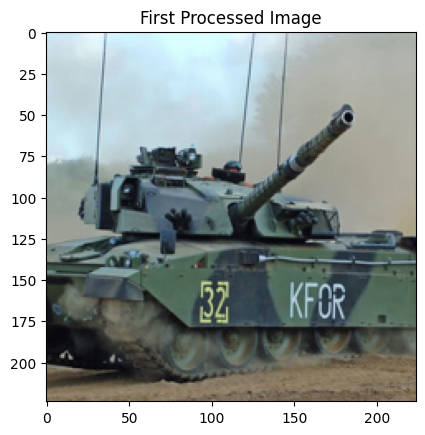

In [440]:
tank_images = ImageProcessor(images_other,model,847)
tank_images.process_images()
tank_images.display_first_image()


In [441]:
tank_images.attack_BIM_all()

In [442]:
tank_images.make_predictions("processed")
tank_images.make_predictions("adversarial")



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Top Predictions for Processed Images:
Image 1: tank, army tank, armored combat vehicle, armoured combat vehicle (Certainty: 0.98)
Image 2: tank, army tank, armored combat vehicle, armoured combat vehicle (Certainty: 0.98)
Image 3: tank, army tank, armored combat vehicle, armoured combat vehicle (Certainty: 0.59)
Image 4: tank, army tank, armored combat vehicle, armoured combat vehicle (Certainty: 0.99)
Image 5: tank, army tank, armored combat vehicle, armoured combat vehicle (Certainty: 0.85)
Image 6: tank, army tank, armored combat vehicle, armoured combat vehicle (Certainty: 0.96)
Image 7: half track (Certainty: 0.50)
Image 8: viaduct (Certainty: 0.08)

-------


Top Predictions for Adversarial Images:
Image 1: plastic bag (Certainty: 0.04)
Image 2: mushroom (Certainty: 0.04)
Image 3: water snake (Certainty: 0.07)
Image 4: thimble (Certainty: 0.21)
Image 5: African grey, African gray, Psittacus erithacus (Certainty: 0.10)
Image 6: jigsaw puzzle (Certainty: 0.05)
Image 7: maze, labyri

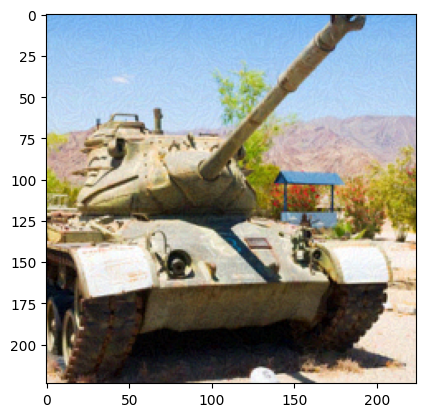

In [443]:
tank_images.show_predictions("processed")
tank_images.show_predictions("adversarial")

tank_images.display_images('adversarial',1)  



In [444]:
"""
copy adverserial image, lets try compression first
"""
adv = 'adversarial_unnormalized'

tank_images.unnormalize_album('adversarial')
tank_images.copy_images(adv,'compress')
tank_images.compress('compress')
tank_images.reprocess_images('compress')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


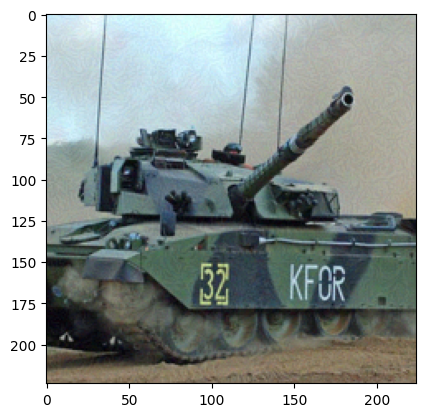

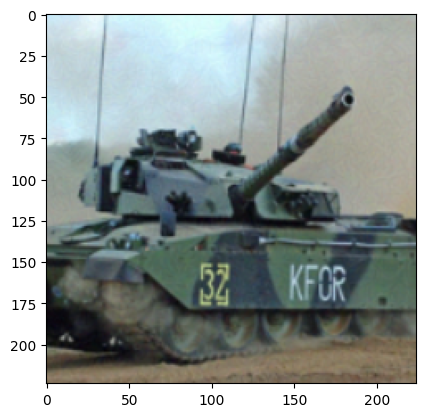

torch.Size([1, 3, 224, 224])


torch.Size([1, 3, 224, 224])

In [445]:
tank_images.display_images('adversarial',0)
tank_images.display_images('compress',0)
print(tank_images.image_data['compress'][0].size())
tank_images.image_data[adv][0].size()


In [446]:
tank_images.make_predictions('compress')
tank_images.show_predictions('compress')

Top Predictions for Compress Images:
Image 1: stretcher (Certainty: 0.05)
Image 2: tile roof (Certainty: 0.03)
Image 3: barrow, garden cart, lawn cart, wheelbarrow (Certainty: 0.10)
Image 4: school bus (Certainty: 0.10)
Image 5: colobus, colobus monkey (Certainty: 0.04)
Image 6: seashore, coast, seacoast, sea-coast (Certainty: 0.08)
Image 7: maze, labyrinth (Certainty: 0.13)
Image 8: mushroom (Certainty: 0.07)

-------




In [447]:
tank_images.calc_loss('processed')
tank_images.calc_loss('compress')

In [448]:
tank_images.display_losses()

Median loss for processed: 0.11356193199753761
Median loss for compress: 7.272367238998413


In [449]:
print(tank_images.compare_albums('adversarial', 'processed'))
tank_images.compare_albums('compress', 'processed')

0.9122589909760432


0.9032644541422911

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 45, 47])


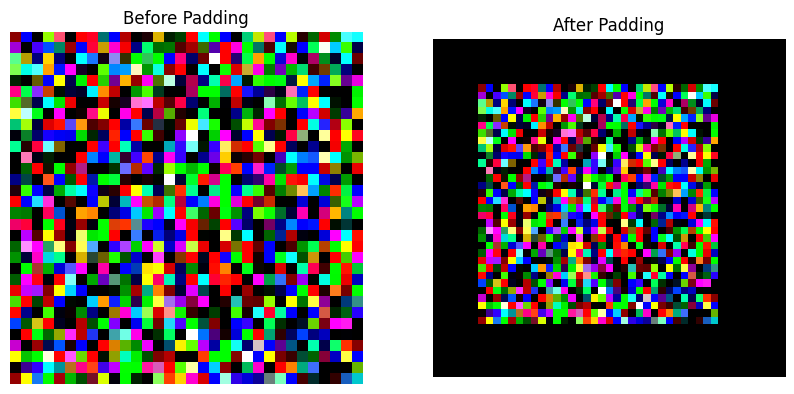

In [450]:
input_tensor = torch.randn(1, 3, 32, 32)
# Define a random padding size; here we'll randomly pad between 0 and 10 pixels on each side
padding_size = torch.randint(0, 10, (4,)).tolist()  # Randomly choose padding sizes for each side (left, top, right, bottom)
pad_transform = transforms.Pad(padding_size)

# Apply the transform to the tensor
padded_tensor = pad_transform(input_tensor)

print(padded_tensor.shape)  # Check the shape of the padded tensor

# Function to display images side by side
def show_side_by_side(img1, img2, title1='Before Padding', title2='After Padding'):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1.permute(1, 2, 0))
    axes[0].set_title(title1)
    axes[0].axis('off')
    
    axes[1].imshow(img2.permute(1, 2, 0))
    axes[1].set_title(title2)
    axes[1].axis('off')
    
    plt.show()

# Display the original and padded images side by side
show_side_by_side(input_tensor.squeeze(), padded_tensor.squeeze())


Top Predictions for Gaussian_t Images:
Image 1: doormat, welcome mat (Certainty: 0.10)
Image 2: fountain (Certainty: 0.05)
Image 3: tile roof (Certainty: 0.13)
Image 4: brass, memorial tablet, plaque (Certainty: 0.06)
Image 5: common iguana, iguana, Iguana iguana (Certainty: 0.10)
Image 6: maze, labyrinth (Certainty: 0.08)
Image 7: maze, labyrinth (Certainty: 0.38)
Image 8: folding chair (Certainty: 0.11)

-------




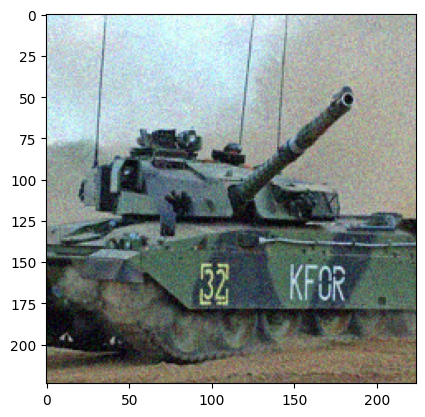

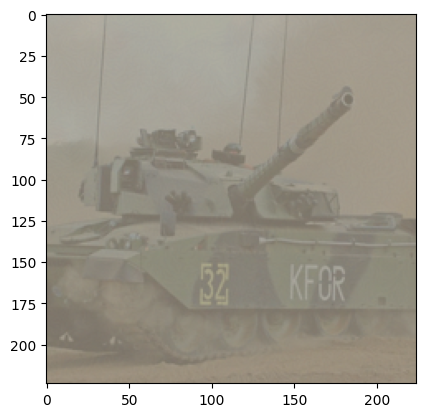

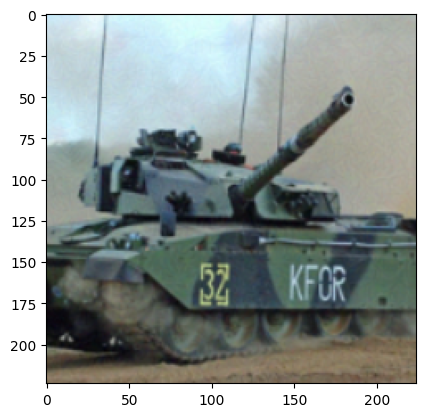

In [451]:
name = 'gaussian_t'
# Copy tank_images and name it suitably
tank_images.copy_images(adv,name)

# Add Gaussian noise to it
tank_images.add_gaussian_noise(name)
tank_images.reprocess_images(name)
# Predict it
tank_images.make_predictions(name)

# Display prediction
tank_images.show_predictions(name)


In [452]:


'''
first attack adverserial
then use a method to run model on existing and advserial
    results should be all the predictions summed, and whats the top 5 class labels

run on adveserial images
run on non adveserial images


'''

'\nfirst attack adverserial\nthen use a method to run model on existing and advserial\n    results should be all the predictions summed, and whats the top 5 class labels\n\nrun on adveserial images\nrun on non adveserial images\n\n\n'

## individual data explore

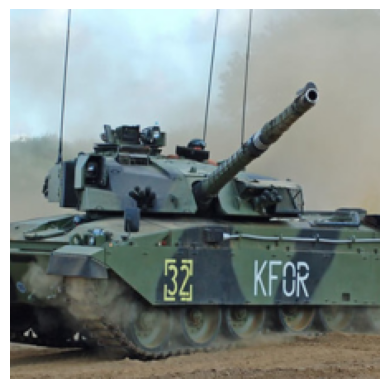

Top 5 Predictions:
tank, army tank, armored combat vehicle, armoured combat vehicle: 96.60%
trimaran: 1.37%
amphibian, amphibious vehicle: 1.20%
catamaran: 0.39%
warplane, military plane: 0.15%


In [453]:
ori_image, adv_image = images[0], adversarial_images[0]

a= show_image_and_predictions(reverse_normalize(ori_image), model(ori_image), label_mapping, top_k=5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


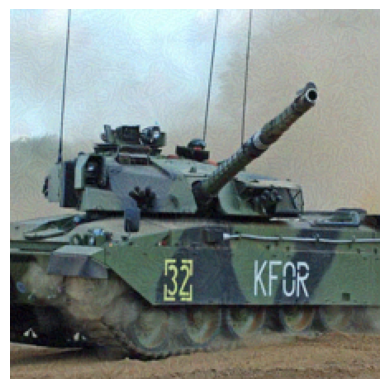

Top 5 Predictions:
plastic bag: 3.09%
paper towel: 2.18%
folding chair: 2.15%
quill, quill pen: 2.12%
pillow: 2.04%


In [454]:
a = show_image_and_predictions(reverse_normalize(adv_image), model(adv_image), label_mapping, top_k=5)

In [455]:
import math

def calculate_percentage_difference(mse, num_channels=3, max_pixel_value=255):
    """
    Calculate the average percentage difference between two images based on the Mean Squared Error (MSE),
    taking into account multiple color channels.

    Parameters:
    mse (float): The Mean Squared Error between two images.
    num_channels (int): The number of color channels (default is 3 for RGB images).
    max_pixel_value (int): The maximum possible pixel value (default is 255 for 8-bit images).

    Returns:
    float: The average percentage difference between the two images.
    """
    # Calculate the average MSE per channel
    mse_per_channel = mse / num_channels
    
    # Calculate the average absolute difference per channel
    average_difference_per_channel = math.sqrt(mse_per_channel)
    
    # Calculate the percentage change per channel
    percentage_change_per_channel = (average_difference_per_channel / max_pixel_value) * 100
    
    return percentage_change_per_channel

In [456]:
# Calculate the difference and give a numerical value

# Difference between ori_image and adv_image
diff1 = torch.sum((ori_image - adv_image) ** 2).item()
print(f"Difference between ori_image and adv_image: {diff1}")

# Difference between reverse_normalize(ori_image) and adv_image_unnormalized
diff2 = torch.sum((reverse_normalize(ori_image) - reverse_normalize(adv_image)) ** 2).item()
print(f"Difference between reverse_normalize(ori_image) and adv_image_unnormalized: {diff2}")

percentage_difference = calculate_percentage_difference(diff2)
print(f"Average percentage difference: {percentage_difference:.2f}%")

Difference between ori_image and adv_image: 872.7437744140625
Difference between reverse_normalize(ori_image) and adv_image_unnormalized: 44.56712341308594
Average percentage difference: 1.51%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

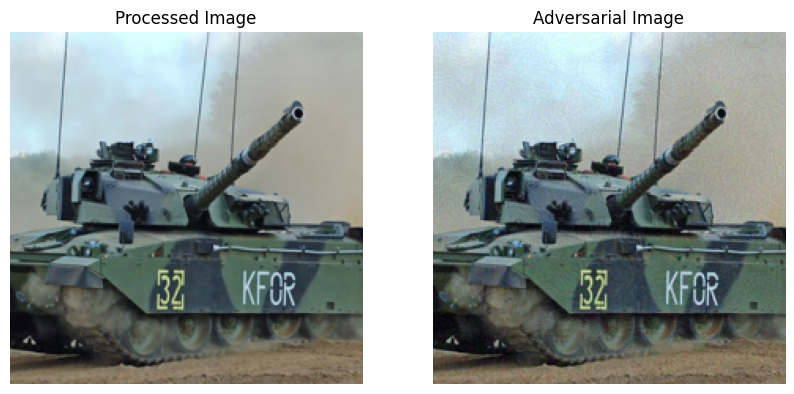

In [457]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot processed_image
axes[0].imshow(reverse_normalize(ori_image).squeeze().permute(1, 2, 0).cpu().detach().numpy())
axes[0].set_title('Processed Image')
axes[0].axis('off')

# Plot adversarial_image
axes[1].imshow(reverse_normalize(adv_image).squeeze().permute(1, 2, 0).cpu().detach().numpy())
axes[1].set_title('Adversarial Image')
axes[1].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


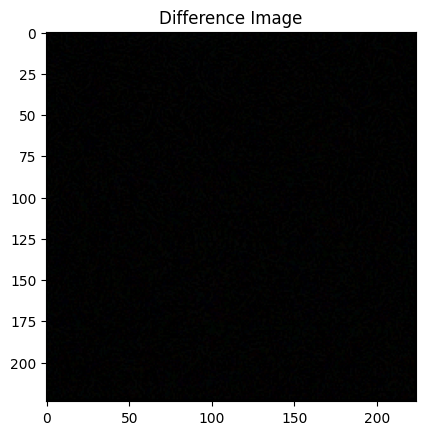

In [458]:
difference_image = (reverse_normalize(ori_image) - reverse_normalize(adv_image)).squeeze(0)
squared_difference_image = difference_image ** 2
# Plot the resulting difference
plt.imshow(difference_image.permute(1, 2, 0).cpu().detach().numpy())
plt.title('Difference Image')
plt.show()